In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import copy
import time
import random
import os

In [2]:
# SET SEED (For Reproducibility)
def set_seed(seed=42):
    """Sets the seed for reproducibility across all libraries."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    # torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to: {seed}")

# Call this before defining datasets or models
set_seed(42)

Seed set to: 42


In [3]:
# 1. CONFIGURATION
DATA_DIR = '/kaggle/input/natural-images/natural_images'  # <--- REPLACE THIS WITH YOUR PATH
NUM_CLASSES = 8
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 2. DATA LOADING & SPLIT
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # ViT Mean/Std Normalization
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load Dataset
full_dataset = datasets.ImageFolder(DATA_DIR, transform=data_transforms)
class_names = full_dataset.classes

# Split Train (80%) / Val (20%)
# Because we set the seed above, this split is now deterministic
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Classes: {class_names}")
print(f"Training on {len(train_dataset)} images, Validating on {len(val_dataset)} images")

Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Training on 5519 images, Validating on 1380 images


In [5]:
# 3. MODEL SETUP (Vision Transformer)
print(f"Loading ViT model on {DEVICE}...")
model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

# 1. Freeze all parameters in the backbone
for param in model.parameters():
    param.requires_grad = False

# 2. Replace the head (New layers have requires_grad=True by default)
input_features = model.heads.head.in_features
model.heads.head = nn.Linear(input_features, NUM_CLASSES)

model = model.to(DEVICE)
print(model)

# 3. IMPORTANT: Pass only the head's parameters to the optimizer
optimizer = optim.Adam(model.heads.head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

Loading ViT model on cuda...


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 220MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [6]:
# ==========================================
# 4. TRAINING LOOP
# ==========================================
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    since = time.time()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stopping_counter = 0

    print("-" * 60)
    
    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total

        # --- VALIDATE ---
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total

        # Store history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss:   {epoch_val_loss:.4f} | Val Acc:   {epoch_val_acc:.4f}")

        # Early Stopping Logic
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
            # Optional: Save checkpoint
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            print(f">>> No improvement. Patience: {early_stopping_counter}/{patience}")
            
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        print("-" * 60)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Loss: {best_loss:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history

# Execute Training
best_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, PATIENCE)


------------------------------------------------------------
Epoch 1/30
Train Loss: 0.1928 | Train Acc: 0.9741
Val Loss:   0.0361 | Val Acc:   0.9978
------------------------------------------------------------
Epoch 2/30
Train Loss: 0.0211 | Train Acc: 0.9993
Val Loss:   0.0188 | Val Acc:   0.9986
------------------------------------------------------------
Epoch 3/30
Train Loss: 0.0111 | Train Acc: 0.9993
Val Loss:   0.0133 | Val Acc:   0.9986
------------------------------------------------------------
Epoch 4/30
Train Loss: 0.0069 | Train Acc: 0.9995
Val Loss:   0.0105 | Val Acc:   0.9986
------------------------------------------------------------
Epoch 5/30
Train Loss: 0.0046 | Train Acc: 0.9998
Val Loss:   0.0090 | Val Acc:   0.9986
------------------------------------------------------------
Epoch 6/30
Train Loss: 0.0033 | Train Acc: 0.9998
Val Loss:   0.0078 | Val Acc:   0.9986
------------------------------------------------------------
Epoch 7/30
Train Loss: 0.0025 | Train A

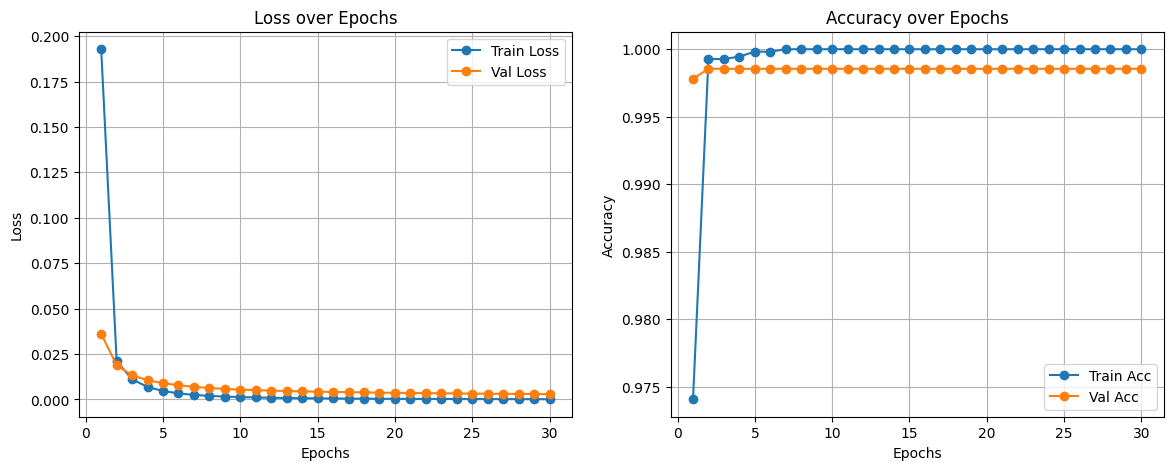

In [7]:
# 5. VISUALIZATION
def plot_results(history):
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(14, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_acc'], label='Train Acc', marker='o')
    plt.plot(epochs_range, history['val_acc'], label='Val Acc', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_results(history)


Classification Report:
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       139
         car       1.00      1.00      1.00       200
         cat       1.00      1.00      1.00       209
         dog       0.99      1.00      0.99       138
      flower       1.00      0.99      1.00       180
       fruit       1.00      1.00      1.00       172
   motorbike       1.00      1.00      1.00       170
      person       1.00      1.00      1.00       172

    accuracy                           1.00      1380
   macro avg       1.00      1.00      1.00      1380
weighted avg       1.00      1.00      1.00      1380



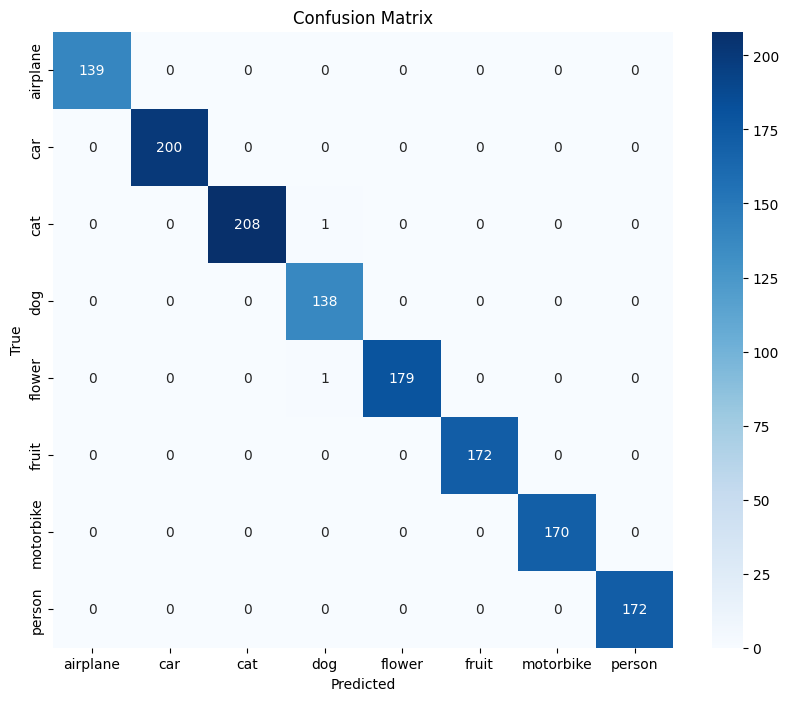

In [8]:
# 6. EVALUATION (Confusion Matrix)
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 2. Confusion Matrix Heatmap
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model(best_model, val_loader)

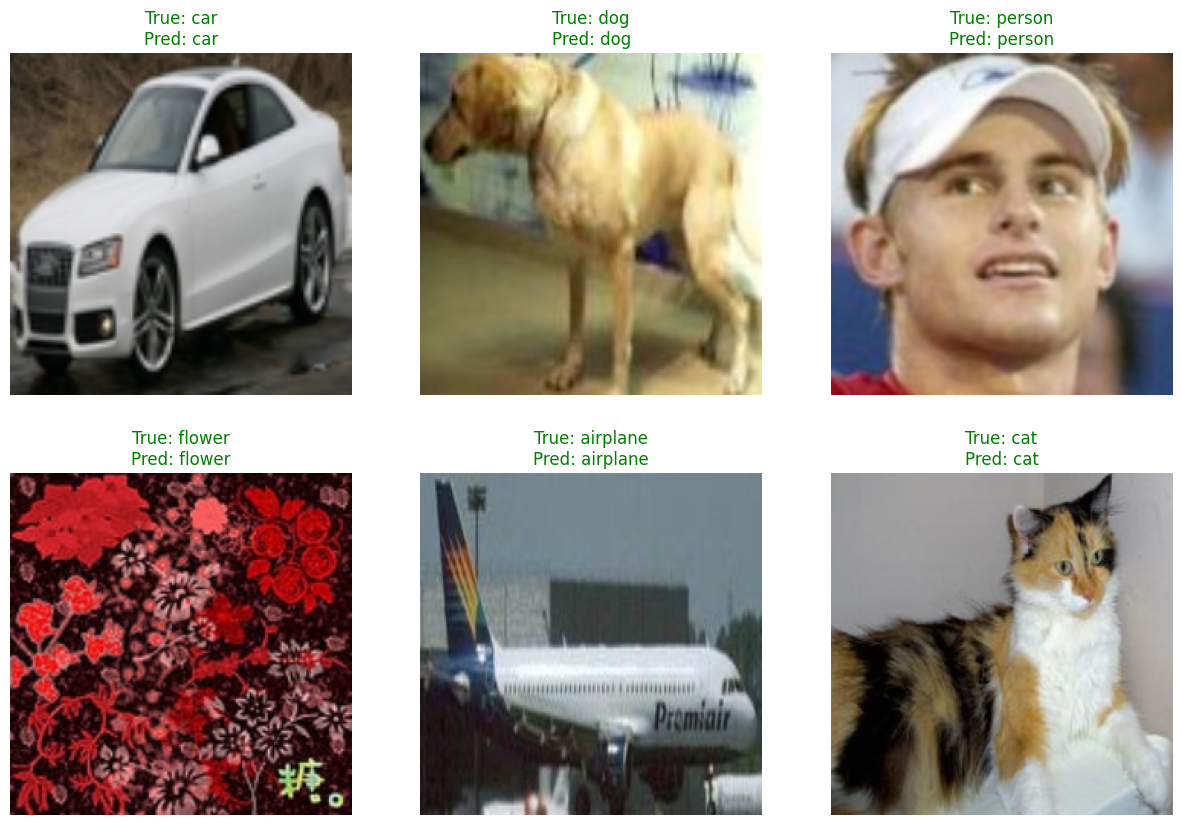

In [9]:
def visualize_predictions(model, loader, class_names, num_images=6):
    model.eval()
    images, labels = next(iter(loader))
    
    # Move to device
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        ax = plt.subplot(2, 3, i + 1)
        
        # Un-normalize image for display
        # Original norm was mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5  # Denormalize
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    
    plt.show()

# Run visualization
visualize_predictions(best_model, val_loader, class_names)

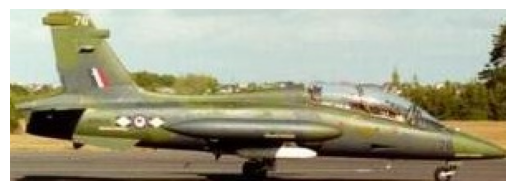

Prediction: airplane
Confidence: 100.00%


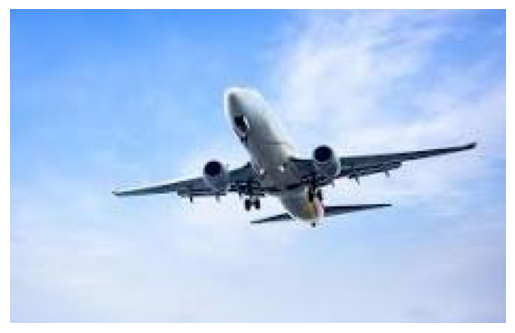

Prediction: airplane
Confidence: 100.00%


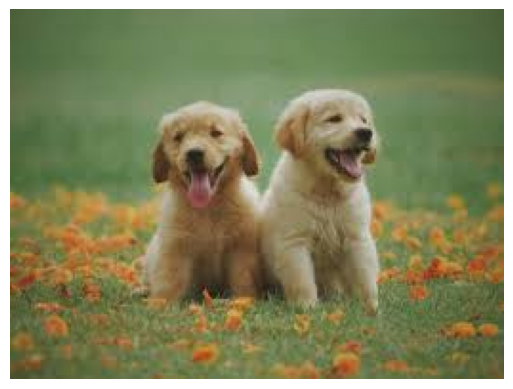

Prediction: dog
Confidence: 99.64%


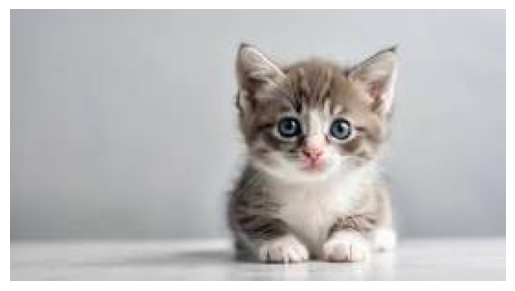

Prediction: cat
Confidence: 100.00%


In [14]:
from PIL import Image

# --- Step 2: Define Inference Function ---
def predict_external_image(image_path, model_path, class_names):
    # 1. Define the same transforms used during training
    inference_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    
    # 2. Re-initialize the model architecture
    # (Must match the architecture defined in your notebook)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.vit_b_16(weights=None) # No need to download weights, we load ours
    
    # Re-create the head (essential step!)
    input_features = model.heads.head.in_features
    model.heads.head = nn.Linear(input_features, len(class_names))
    
    # 3. Load state dict
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # 4. Load and preprocess image
    try:
        image = Image.open(image_path).convert('RGB')
        # Display the image we are testing
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        
        input_tensor = inference_transforms(image).unsqueeze(0) # Add batch dimension
        input_tensor = input_tensor.to(device)
        
        # 5. Predict
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, pred_idx = torch.max(probs, 1)
            
        predicted_class = class_names[pred_idx.item()]
        conf_score = confidence.item() * 100
        
        print(f"Prediction: {predicted_class}")
        print(f"Confidence: {conf_score:.2f}%")
        
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")


predict_external_image('natural_images/airplane/airplane_0000.jpg', 'natural_images_vit.pth', class_names)
predict_external_image('airplane.jpg', 'natural_images_vit.pth', class_names)
predict_external_image('dog.jpg', 'natural_images_vit.pth', class_names)
predict_external_image('cat.jpg', 'natural_images_vit.pth', class_names)